# Clustering - GMM

In [1]:
from scipy.stats import multivariate_normal
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
mv_path = "./Assignment 8 datasets/mv.csv"
unif_path = "./Assignment 8 datasets/unif.csv"
mv2_path = "./Assignment 8 datasets/mv2.csv"
mv3_path = "./Assignment 8 datasets/mv3.csv"

# Read in Data
mv_df = pd.read_csv(mv_path, index_col = 0)
unif_df = pd.read_csv(unif_path, index_col = 0)
mv2_df = pd.read_csv(mv2_path, index_col = 0)
mv3_df = pd.read_csv(mv3_path, index_col = 0)

In [3]:
mv_df.head()

,x,y,cat
0,-1.447457,0.912278,0
1,-1.103909,-0.638752,0
2,-0.649668,0.954469,0
3,-1.498370,-0.160686,0
4,-0.951470,-0.369971,0


Cluster Assignments

$$\phi_i(k) = \frac{\pi_k N(x_i|\mu_k,\Sigma_k)}{\sum_j \pi_j N(x_i|\mu_j,\Sigma_k)},$$ 

In [4]:
def assign_clusters_GMM(points, clusters):
    def pdf_calc_func(mu, pi, Sigma):
        return lambda x: pi*stats.multivariate_normal(mu,Sigma).pdf(x)
    clust_weights=[]
    for c in clusters:
        pdf = pdf_calc_func(*c)
        clust_weights.append(np.apply_along_axis(pdf,1,points).reshape(-1,1))
    clust_weights=np.concatenate(clust_weights, axis=1)
    def norm_clust_weights(x):
        return [n/np.sum(x) for n in x]
    cluster_assign=np.apply_along_axis(norm_clust_weights,1,clust_weights)
    return cluster_assign

Cluster Updates

$$\mu_k = \frac1{n_k}\sum\limits_{i=1}^n \phi_i(k)x_i,\quad  \text{with}\quad  n_k=\sum\limits_{i=1}^n\phi_i(k),$$

$$\pi_k = \frac{n_k}{n},\quad \text{with} \quad n_k=\sum\limits_{i=1}^n\phi_i(k),$$

$$\Sigma_k = \frac1{n_k}\sum\limits_{i=1}^n\phi_i(k)(x_i-\mu_k)(x_i-\mu_k)^T.$$

In [5]:
def update_clusters_GMM(points, cluster_weights):
    new_clusts=[]
    for c in cluster_weights.T:
        n_k=np.sum(c)
        pi_k=n_k/len(points)
        mu_k=np.apply_along_axis(np.sum,0,points*c.reshape(-1,1))/n_k
        #print(mu_k)
        #new_clusts.append(mu_k)
        Sigma_k=0
        for cw,p in zip(c,points):
            diff=p-mu_k
            Sigma_k+=cw*np.matmul(diff.reshape(-1,1),diff.reshape(1,-1))
        Sigma_k=Sigma_k/n_k
        new_c=(mu_k,pi_k,Sigma_k)
        new_clusts.append(new_c)
    return new_clusts

In [6]:
#K-means-like approach to initialize centers
#provided


def pick_cluster_centers(points, num_clusters = 3):
    # Create List to store clusters
    clusters = []
    
    # Save list of cluster indicies
    arr_idx = np.arange(len(points))
    
    # Choose first cluster; append to list
    clusters.append( points[np.random.choice(arr_idx)])
    
    # Define function to calculate squared distance
    def dist_sq(x): return np.linalg.norm(x)**2
    
    c_dist = None

    # Add Clusters until reaching "num_clusters"
    while len(clusters) < num_clusters:
        
        # Calculate distance between latest cluster and rest of points
        new_dist = np.apply_along_axis(np.linalg.norm, 1, points - clusters[-1]).reshape(-1,1)
        
        # Add to distance array - First check to see if distance matrix exists
        if type(c_dist) == type(None):
            c_dist = new_dist
            
        else:
            c_dist = np.concatenate([c_dist, new_dist], axis = 1)
        
        # Calculate probability by finding shortest distance, then normalizing
        c_prob = np.apply_along_axis(np.min, 1, c_dist)
        c_prob = c_prob / c_prob.sum()

        # Draw new cluster according to probability
        clusters.append(points[np.random.choice(arr_idx, p = c_prob)])
            
    return np.array(clusters)


In [7]:
def build_GMM_clusters(clusters):
    return [(c, 1/len(clusters), np.array([[1,0],[0,1]])) for c in clusters]

In [8]:
# Create function that will create clustering functions
def create_cluster_func(assign_func, update_func, threshold_func, assign_args = {}):
    
    def cluster(points, centroids, max_iter = 100, stop_threshold = .001):
        for i in range(max_iter):
            old_centroids = centroids
            
            cluster_weights = assign_func(points, centroids, **assign_args)
            centroids = update_func(points, cluster_weights)
            
            if threshold_func(centroids, old_centroids, stop_threshold):
                break        
        return centroids
    return cluster

def basic_threshold_test(centroids, old_centroids, stop_threshold):    
    for n, o in zip(centroids, old_centroids):       
        if np.linalg.norm(n-o) > stop_threshold:
            return False
    return True

def GMM_threshold_test(centroids, old_centroids, stop_threshold):
    for np, op in zip(centroids, old_centroids):
        if not basic_threshold_test(np,op,stop_threshold):
            return False
    return True


In [9]:
cluster_GMM = create_cluster_func(assign_clusters_GMM,
                                  update_clusters_GMM,
                                  GMM_threshold_test)

In [10]:
# Visualization function for GMM
from sklearn.mixture import GaussianMixture

def plot_GMM(clusters = 3):
    # Create figure
    fig, (axs) = plt.subplots(2,2, figsize = (6,6))
    cents0=[]
    cents1=[]
    
    # Go thorugh all data sets 
    for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
        
        # Pull out point data
        points = df.iloc[:,:2].values
       
        
        # Pick random initial centers
        init_cents = pick_cluster_centers(points, clusters)      
        cents_p_cov=build_GMM_clusters(init_cents)
      
        # Calculate centers from custom function
        cents_pc = cluster_GMM(points ,cents_p_cov)        
        for i in range(clusters):
            cents0.append(cents_pc[i][0][0])
            cents1.append(cents_pc[i][0][1])
        
        # Calculate centers from sklearn       
        gmm=GaussianMixture(n_components=clusters).fit(points)
        centers = np.empty(shape=(gmm.n_components, points.shape[1])) 
        
        for i in range(gmm.n_components):
            density = stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(points)
            centers[i, :] = points[np.argmax(density)]
    
        # Plot each distribution in different color
        for cat, col in zip(df['cat'].unique(), ["#1b9e77", "#d95f02", "#7570b3"]):
            ax.scatter(df[df.cat == cat].x, df[df.cat == cat].y, label = None, c = col, alpha = .15)
            
        # Plot Calculated centers      
        ax.scatter(cents0, cents1, c = 'k', marker = 'x', label = 'Custom', s = 70)
        ax.scatter(centers[:,0], centers[:,1], c = 'r', marker = '+', label = 'sklearn', s = 70)
        
        # Add legend
        ax.legend()
        
        # Reset
        cents0=[]
        cents1=[]

Wall time: 7min 24s


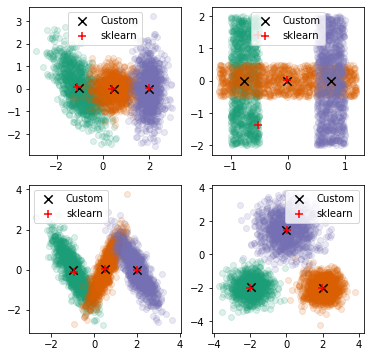

In [11]:
%%time
plot_GMM(3)